## Predicting Beer Reviews
> Griffin Davis and Sydnee Haney

In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from urllib.request import urlopen, HTTPError
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.preprocessing import LabelEncoder, StandardScaler


#### Load in Data

In [242]:
fr = None
try:
    fr = open('../Datasets/beer_ratings.json', 'r')
except FileNotFoundError:
    try:
        fr = urlopen(
            'https://raw.githubusercontent.com/davisgriffin/Machine_Learning/main/Datasets/beer_ratings.json')
    except HTTPError:
        raise Exception('Cannot read data')
beer_ratings = pd.read_json(fr, orient='records')
fr.close()

#### Create Dataframes

In [243]:
X = beer_ratings[['beer/ABV', 'user/ageInSeconds',
                  'user/gender', 'review/timeStruct', 'beer/style', 'review/overall']].copy()

# Convert timeStruct of form {'mday': 22, 'mon': 11} to 1122
X['review/timeStruct'] = [int("{}{}".format(*(timeStruct['mon'], timeStruct['mday'])))
    for timeStruct in X['review/timeStruct']]
    
X = X.dropna()
y = X['review/overall']
X.drop(columns='review/overall', inplace=True)
X = pd.get_dummies(X)

# Ensure same split for logistic regression later
# Even with this it cannot definitively be said which model is better. Sometimes
# linear wins and sometimes logistic wins. 
random_state = randint(0,1000000)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=random_state)
X_train

,beer/ABV,user/ageInSeconds,review/timeStruct,user/gender_Female,user/gender_Male,beer/style_Altbier,beer/style_American Adjunct Lager,beer/style_American Amber / Red Ale,beer/style_American Amber / Red Lager,beer/style_American Barleywine,...,beer/style_Schwarzbier,beer/style_Scotch Ale / Wee Heavy,beer/style_Scottish Ale,beer/style_Scottish Gruit / Ancient Herbed Ale,beer/style_Smoked Beer,beer/style_Tripel,beer/style_Vienna Lager,beer/style_Wheatwine,beer/style_Winter Warmer,beer/style_Witbier
42309,8.0,9.970238e+08,521,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46106,6.2,1.037283e+09,1112,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
36182,6.0,1.025017e+09,922,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34085,6.5,8.830586e+08,1215,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30711,7.2,1.085065e+09,620,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25372,6.6,1.579702e+09,120,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36237,6.0,9.628094e+08,723,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10452,4.7,9.819002e+08,428,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31013,10.4,9.890750e+08,89,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Create Linear Model

In [244]:
lin = LinearRegression().fit(X_train, y_train)
lin_prediction = lin.predict(X_test)
score = lin.score(X_test, y_test)
print('''R^2: {:.4f}
Mean Absolute Percentage Error: {:.4f}%'''.format(score, MAPE(y_test, lin_prediction)*100))

R^2: 0.1551
Mean Absolute Percentage Error: 14.4868%


#### Create Logistic Dataframes

In [245]:
# Encode and Scale values
le = LabelEncoder()
scaler = StandardScaler()

# create multiclass labels to replace floats
X_log = X.copy().apply(le.fit_transform)
le.fit(y)
y_log = le.transform(y.copy()) # separate fit and transform to invert later

# scale data for convergence
X_log = scaler.fit_transform(X_log)

X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.2, shuffle=True, random_state=random_state)

#### Create Logistic Model

In [246]:
log = LogisticRegression(tol=5e-1, max_iter=100).fit(X_train, y_train)
log_prediction = log.predict(X_test)
score = log.score(X_test, y_test)

# transform multiclass labels back to 5-star rating
log_prediction = le.inverse_transform(log_prediction)
y_test = le.inverse_transform(y_test)

print('''R^2: {:.4f}
Mean Absolute Percentage Error: {:.4f}%'''.format(score, MAPE(y_test, log_prediction)*100))

R^2: 0.3774
Mean Absolute Percentage Error: 14.3790%


#### Visualizing Predictions

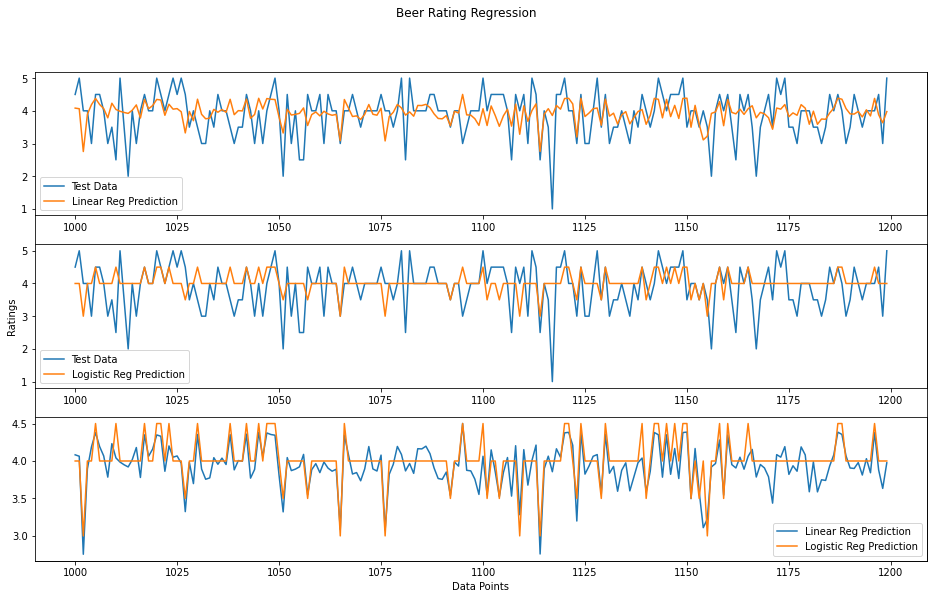

In [247]:
data_min = 1000
data_max = 1200

plt.close('all')
x = np.arange(0, len(lin_prediction))
fig = plt.figure()
ax = fig.add_subplot(111)
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax.tick_params(
    axis='both',
    which='both',
    bottom=False,
    left=False,
    labelbottom=False,
    labelleft=False
)

ax3.set_xlabel('Data Points')
ax2.set_ylabel('Ratings')
fig.suptitle('Beer Rating Regression')

ax1.plot(x[data_min:data_max], y_test[data_min:data_max], label='Test Data')
ax2.plot(x[data_min:data_max], y_test[data_min:data_max], label='Test Data')

ax1.plot(x[data_min:data_max], lin_prediction[data_min:data_max], label='Linear Reg Prediction')
ax3.plot(x[data_min:data_max], lin_prediction[data_min:data_max], label='Linear Reg Prediction')

ax2.plot(x[data_min:data_max], log_prediction[data_min:data_max], label='Logistic Reg Prediction')
ax3.plot(x[data_min:data_max], log_prediction[data_min:data_max], label='Logistic Reg Prediction')

ax1.legend()
ax2.legend()
ax3.legend()

fig.set_size_inches(16, 9, forward=True)
plt.show()